## DoEgen Synrift Example

![](images/doegen_exp_design_small.png)
### DoEgen Excel configuration file

| Parameter Name      | Parameter Type | Level Number     | Minimum | Maximum | Include (Yes/No)    | Levels    |
| :---        |    :----:   |          ---: |          ---: |    :----:   |          ---: |          ---: |
| Precipitation      | Continuous       | 3   | 1.5   | 2       | Yes  |     |
| Erodibility   | Continuous        | 6      | 9.00E-07      | 1.00E-05        | Yes      |       |
| Tectonic   | Categorical        | 2      |        |          | Yes      |  scenario_tect_1event.xml,scenario_tect_3event.xml |
| Initial Topography   | Categorical        |        |        |          | No      |  07_DEM_cf_lim_initial.dat |

An example of the format of the excel input file is above and the excel file to use is included in the model directory:
* parameters flagged **Yes** in
 the include column will be evaluated in the DoEgen process and variations according to the parameter type, level number, maximum and minimum used as input for experiment configuration files. 
* paremeters flagged **No** are not used for the DoEgen experiment optimisation, however they are used to generate the experiment/model xml configuration files. Values & strings will be read from the Levels column and kept constant across all experiments.

Next we load the modules required for the DoEgen process to run


In [ ]:
#install the badlands_doe_toolset
!pip install badlands-doe-toolset

In [ ]:
import doegen.doegen as doegen
import doegen.doeval as doeval
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # deprecation warnings from DoEgen are supressed
import badlands_doe_toolset.csv_to_badlands as genxml #DoEgen badlands csv to xml generation 
import os
import contextlib
import badlands_doe_toolset.postproc_utils as ppu
import numpy as np

## Run DoEgen main process ##

The ***DoEgen.main*** module outputs to stdout and makes it difficult to follow jupyter notebooks. Here, to improve readability, stdout is temporarily redirected to a log file.

doegen.main is executed with the name of the excel confguration file as it's primary input. The outpath will be the location the model results are saved to. This process may take some time and the outputs will be written sequentially to the outpath (this directory can be checked during the run to check on progress)


Key parameters are: 
  * **nrun_max**: the maximum number of experiments that DoEgen will evaluate
  * **maxtime_per_run**: DoEgen uses oapackage to generate orthoganal arrays(https://oapackage.readthedocs.io/) from oapackage: "Maximum running time of the algorithm. If this time is exceeded the algorithm is aborted."

## Outputs 

 **outpath/Experiment_Design_selection_summary.txt** summarises the results and recomends the optimal and/or best set of configurations for the badlands model.

The Efficiencies plot is arguably the most useful way to demonstrate the optimal number of Experiments to run, the example below shows that almost all parameters reach maximum efficiency only when more than ~100 Experiments are run and the efficiencies do not improve significantly beyond the optimal number of experiments.

![](images/300_DOE_test.PNG)
 
As each Experiment set is generated and evaluated by DoEgen, a folder is added to the outpath with with the results of that evaluation.


In [ ]:
# Run the main DoEgen process to build the experiment design tables and evaluate inputs
# redirect output to log file
# calls DoEgen and loads the excel file with configuration parameters
with open('doegen_log.txt', 'w') as f:                  
    with contextlib.redirect_stdout(f):
        doegen.main('Experiment_setup_badlands.xlsx',\
            path='.', \
            outpath='design_results/', \
            nrun_max=150, \
            maxtime_per_run=120, \
            delta_nrun=6)                               

# at the end of the process, print the design result summary
with open('./design_results/Experiment_Design_selection_summary.txt') as f:
    b = f.read()
    print (b)
    


In [ ]:
# Now we need to create the badlands model configuration files (xml) from the csv of proprties that DoEgen has generated.
# Select the file that has the best or optimal number of runs as desired after reviewing the efficients plot and outputs.
!ls design_results

## Generate the Badlands experiment configuration files.

The minimum, optimal or best design table produced by the DoEgen module is used to generate the experiment configuration files. 
Here the csv to xml generator uses parameters that I need but it can easily be modified further to include parameters needed by others.

The design table is a csv file and if required, it may be examined in excel or a text editor.

Review the DoEgen outputs and select the appropriate design table to generate the experiment configurations.


In [ ]:
# This creates the models xml files using the selected DoEgen Design Table (csv file)
# Doegen will generate a combination of best, optimal, minimum files with parameters to generate the xml, 
# review the outputs to determine which is the most appropriate design table to run. Here we use the Optimal design table.

import badlands_doe_toolset.csv_to_badlands as genxml
genxml.main('design_results/Designtable_best_Nrun90.csv')



## Run the Badlands experiments in parallel

Once the Experiment configuration files are generated, the experiments can be loaded and run by Badlands. The multiproc_run module gets the list of xml files from the xml directory then sends those to the multiprocessor command to execute "proc" parallel experiment runs. 

Within the multiproc_run module the usual badlands model progress outputs are redirected to the log directory files once a model run is complete.

## Some notes on the use of multiprocessing in Badlands

Badlands processes do not make use of multiple threads or processors. However, some modules that badlands calls do use multiple threads, for example the GFlex module uses multiple threads / cores. This may mean that multiprocessing in some cases is optimally run with lower number of threads or processes.

The optimal number of procs to assign to the Experiment set can be worked out by trial and error or by running the test module.  Bottlenecks may be encountered before all CPU threads can be used. Optimisation of this is not covered here.

The default behaviour is to use 0.5 * the total number of threads available. Note, that for this example, 20 parallel experiment runs use ~95GB of ram.

the optimisation test utility (mpr.badlands_optimise_multiproc) sets the badlands model run to 2 the visualisation, then re-runs this increasing the number of procs by 2 for each step.

A simple utility is available to help guess the optimal number of processes. See the included notebook. 
```
import badlands_doe_toolset.badlands_multiproc_run as mpr
speed_test=mpr.badlands_optimise_multiproc('badlands_xml')
for i in range(0,len(speed_test)):
    print (speed_test[i])
```


In [ ]:
# the default setting here is for 1/2 the number of threads / processors available on your PC to be used.
# Alternately you can set it using the proc=XX argument.

import badlands_doe_toolset.badlands_multiproc_run as mpr
experiment_run=mpr.badlands_multi_experiment('badlands_xml', proc=11)

# save successfully run experiments and time as a list
run_times=experiment_run.get()
# print (output_times)


## Post Processing

Badlands experiments produce data outputs in 3 file types, each has their own location. The **XX** in the file name represents the model step, ie in a 30 million year experiment with a 100,000 year timestep there will be 300 timesteps. Each file will named from tin.time1.hdf5 through to tin.time300.hdf5

**tin.timeXX.hdf5**
: a snapshot of the surface geometry attributes at each timestep specified in the experiment configuration. 

|tinfile|      |X/Y/Z    | EroDep  |EroDep failure|EroDep hillslope|           |Pitfill      |
| :--- | :---  |:---    |:---     |:---     |:---     |:---       |:---  |   
| area | cells | coords | cumdiff | cumfail | cumhill | discharge | lake |

  
**flow.timeXX.hdf5**
: a snapshot of the flow related attributes at each timestep specified in the experiment configuration. 

|flowfile|     |     |  X/Y/Z    |         |         |              |Calculated|
| :--- | :---  |:---    |:---     |:---     |:---         |:---     |:---  |   
| basin| chi   | connect| coords  |discharge| flowdensity | sedload | fetch |


**sed.timeXX.hdf5**
: Also referred to as the stratal file. This is the 3D geometry of the experiment at each step, however in the DoEgen implementation, the experiment is configured so that only the final sed.time.XX.hdf5 file is written to disk as only the final stratigraphic position is required for this evaluation. The files are also large and rapidly consume all available disk space when multiple experiments are run. Once the most appropriate experiment is determined, if this output is required a subset of experiments can be re-run with a stratal file produced at each timestep.

|stratfile|      |     |         |         |         |           | |
| :--- | :---  |:---    |:---     |:---     |:---     |:---       |:---  |   
| coords | layDepth | layElev | layPoro | layThick |   |   |   |
    
    
Some of the parameters in the tin and flow files can be used as psuedo (proxy?) environmental or depositional indicators. For example, the EroDep parameter in the tin file may be used to determine depositional rate, similarly, using the porosity parameter to decompact the thickness parameter in the stratal file may give the rate of deposition.

In this example, the lake or pitfill parameter is used as a proxy for water depth in terrestrial systems.

**Additional post processed calculated attributes - for details see the post processing workflow notebok**


|Attribute| comment|
|:---     |:---    |
|instdiff | the difference betwenn cumdiff and step(n) and step(n-1) or, the rate of erosions/deposition per time step.**
|fetch    | upstream area from specified node, created in flow.timeXX.hdf5 dataset|
|dthick   | decompacted thickness from layPoro/layThick|

** Note instdiff is calculated and added to sed.time by default when cumdiff is interpolated onto the stratal grid.  


## Interpolate to final stratal file

To enable the tin and flow file data to be evaluated in their final positions (depth), selected attibutes from these files are extracted or calculated and then interpolated onto the equivalent layer in the final stratal file.


## postproc_utils

The tin.time and flow.time contain the environmental parameters. In this case **Lake depth** at each point is in the **tin.timeXX.hdf5** file at each timestep. We want to compare the lake depth with interpreted environmental data obtained from a well. The final sed.timeXX.hdf5 (or stratal) file records the final depth of each timestep. 
So here we interpolate the Lake parameter from each tin.time timestep, to the stratal file in depth.

In this case, the multiprocessor function is used with the default being to use all but 2 of the threads available.

**Outputs:**  

* Lake level interpolated into stratal file is useful for me.
* fetch, generated from the connect array in the flow.time file is useful in terestrial basins. 
* an additional property "instdiff" is calculated from the cumdiff increasein each timestep. 
* any of the attributes present in the tin.time and flow,time files can be interpolated onto the final sed.time file. If an attempt to interpolate a property that does not exist is made then an error will stop the process. All models need to have completed successfully. 

**NOTE: The attributes must be referenced by their name in the HDF5 file. For example, erodep is named cumdiff in tin.timexx.hdf5**

In [9]:
# Once the model run is complete, some postprocessing can be done.
# function input is the location (directory) of the model xml files and a list of attributes that exist in the TIN file.
# The attributes will be interpolated onto the strat file for each experiment
# ppu.strat_tin_write(attribs, modelfile) is the single model version of this.

import badlands_doe_toolset.postproc_utils as ppu

attributes=['lake','cumdiff'] #this will also add the instdiff attribute.
ppu.strat_tin_write_doegen('badlands_xml',attributes,proc=7)


Checking XML files are valid. If there is an error after this then there is something wrong with your configuration xml.
All good, simple xml check passed, number of experiment configuration files loaded: 90
number of threads available here: 24
number of processes assigned: 7
adding ['lake', 'cumdiff'] to Experiments/experiment_21/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_13/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_9/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_1/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_5/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_25/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_17/h5/sed.time300.hdf5


/root/.local/lib/python3.9/site-packages/badlands_doe_toolset-0.1.4-py3.9.egg/badlands_doe_toolset/postproc_utils.py:226: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/root/.local/lib/python3.9/site-packages/badlands_doe_toolset-0.1.4-py3.9.egg/badlands_doe_toolset/postproc_utils.py:226: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/root/.local/lib/python3.9/site-packages/badlands_doe_toolset-0.1.4-py3.9.egg/badlands_doe_toolset/postproc_utils.py:226: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

writing to file
cumdiff specified, generating instdiff as well
writing to file
cumdiff specified, generating instdiff as well
writing to file
cumdiff specified, generating instdiff as well
writing to file
writing to file
cumdiff specified, generating instdiff as well
cumdiff specified, generating instdiff as well
completed Experiments/experiment_5/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_6/h5/sed.time300.hdf5
writing to file
cumdiff specified, generating instdiff as well
completed Experiments/experiment_25/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_26/h5/sed.time300.hdf5
writing to file
cumdiff specified, generating instdiff as well
completed Experiments/experiment_13/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_14/h5/sed.time300.hdf5
completed Experiments/experiment_17/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_18/h5/sed.time300.hdf5
completed Experiments/experiment_

completed Experiments/experiment_84/h5/sed.time300.hdf5
completed Experiments/experiment_86/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_87/h5/sed.time300.hdf5
writing to file
cumdiff specified, generating instdiff as well
completed Experiments/experiment_90/h5/sed.time300.hdf5
writing to file
cumdiff specified, generating instdiff as well
completed Experiments/experiment_87/h5/sed.time300.hdf5
adding ['lake', 'cumdiff'] to Experiments/experiment_88/h5/sed.time300.hdf5
writing to file
cumdiff specified, generating instdiff as well
completed Experiments/experiment_88/h5/sed.time300.hdf5
All outputs written to final stratigraphy file in depth: 239.8 minutes



## Extract data from psuedo well locations in all experiments

Once all the required data is in depth the experiments are queried to return the information where we have observations to compare. In this case, we extract the Lake parameter and the decompacted thickness, which in this case is equivalent to a deposition rate.

The input required for this operation is the location of the well file in this case **'data/well_location_model.csv'** and the directory with the experiment configuration (xml) files. The output is written to a hdf5 formatted file so it can be retrieved later for analysis and this file is referenced below.

The psuedo well, experiment query is done sequentially and may take some time.



In [10]:
# here we extract the lake level and timestep from final sed.time file at given well locations in depth

import badlands_doe_toolset.postproc_utils as ppu
Experiment=ppu.extract_WellLayer_all('badlands_xml', 'data/well_location_model.csv',
                                     outfile='experiment_well_extracts_90_lake.hdf5',
                                    outdir='results_final/')

# One aim here was to keep enough information in this output to reduce the potential for errors when comparing models later.
# so the output contains the experiment name, well name and some of the paramters used to build the model.


Checking XML files are valid. If there is an error after this then there is something wrong with your configuration xml.
All good, simple xml check passed, number of experiment configuration files loaded: 90
load data from: Experiments/experiment_1/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_2/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_3/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_4/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_5/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_6/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_7/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_8/h5/sed.time300.hdf5
4 psuedo well loc

4 psuedo well locations added to results
load data from: Experiments/experiment_80/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_81/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_82/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_83/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_84/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_85/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_86/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_87/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_88/h5/sed.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/expe

## Compare to well logs and evaluate

We now have an Nexps * Nwells pile of data to evaluate.
First, we iterate through each psuedo well in each experiment and compare it with the measured/expected data from the actual well.

For this approach to work, there needs to be a strong link between the expression of an environmental parameter measured in a well log and an environmental parameter extracted from the experiment runs. The link between the parameters may vary across a models area. 

In this case, a comparison is made between the Lake property at the psuedo well and measured Gamma Ray logs from the actual well in the *data/well_location_model.csv* file, the GR log file for each well is named in the last column and must be in the data/ directory. In some wells there is a correlation between water depth and Gamma Ray.

Depending on the vertical resolution of the experiments (the timestep) the GR log will need to be smoothed, in this case it has been resampled to a ~1m interval in the input file with additional gaussian smoothing in this process. 
The outputs are a set of similarity measures for each well/psuedo well/experiment combination. Values closer to 0 are more similar.

Determining which paramter to evaluate for similarity will depend on your experiment. In this case, the 'lake' attribute may be useful when compared to a well log gamma ray. HOWEVER a more robust approach wold be to create a water depth curve from measured and available well data.

False positives are possible and some filtering has been implemented to remove the most obvious of these.

 
***similarity" measurements are determined using the python similarity measures package. https://pypi.org/project/similaritymeasures/***

## Generate doegen DoEval input files

The DoEval module provides statistcal analysis of the experiment results. It is useful to examine these properties averaged over an entire experiment and also for each well. 
Initially, we examine the thickness of sediment accumulated in each experiment by comparing the measured thickness in each well to the experimental values across each experiment.

Following that, we examine wells where the experiment thickness to actual thickness ratio is above a threshold (here we use 0.8) 


In [ ]:
#Iterate through wells & experiments comparing observed with experiment results

import badlands_doe_toolset.well_doe_similarity as wsm

model_extract='results_final/experiment_well_extracts.hdf5'
wellfile='data/well_location_model.csv'

g=wsm.exp_thickness_doeval(model_extract,wellfile,expattrib='cumdiff',outdir='results_final')

# evaluate dataframe
g

In [11]:
#Iterate through wells & experiments comparing observed with experiment results.
# produce a table of 

#!pip3 install similaritymeasures # check to see you've installed this.

import badlands_doe_toolset.well_doe_similarity as wsm
model_extract='results_final/experiment_well_extracts_90_lake.hdf5' # the model extracts hdf5 file.
wells_file = 'data/well_location_model.csv' # the location of the file with information about all wells.

obslog='GR' # the name of the log/observation column in the csv file.
expattrib='Lake' # the name of the attibute in the hdf5 extracted values
minthkRatio=0.8 # experimental thickness / measured thickness cutoff ratio for evaluating the obslog/expattrib similarity.

analysis_results=wsm.exp_attr_sim_DoEgen(model_extract,obslog,expattrib,wells_file,minthkRatio,exp_srm=5,log_smth=10,outdir='results_final')


Starting well sim comparisons in parallel: 24 processes
90 experiments
experiment_14experiment_12experiment_10experiment_11experiment_13experiment_1experiment_15experiment_17experiment_16experiment_18experiment_2experiment_19experiment_20experiment_21experiment_22experiment_23experiment_24experiment_25experiment_27

experiment_28experiment_29experiment_3experiment_26experiment_30





















experiment_32experiment_38experiment_34experiment_35experiment_36experiment_33experiment_4experiment_39experiment_40experiment_41experiment_42experiment_43experiment_45experiment_44experiment_37experiment_46experiment_47
experiment_48experiment_49experiment_5experiment_50experiment_51



experiment_52

















experiment_31
experiment_53
experiment_54
experiment_55experiment_57experiment_58experiment_56

experiment_60experiment_59
experiment_62experiment_64experiment_66
experiment_65experiment_63experiment_61experiment_68
experiment_67
experiment_7experiment_70experiment_71


exper

KeyError: "Unable to open object (object 'Lake' doesn't exist)"

## Run the DoEval module to analyse results 

The well similarity module generates files suitable for use in DoEval.

The DoEval module provides statistcal analysis of the experiment results. It is useful to examine these properties averaged over an entire experiment and also for each well. 
Initially, we examine the thickness of sediment accumulated in each experiment by comparing the measured thickness in each well to the experimental values across each experiment.

Following that, we examine wells where the experiment thickness to actual thickness ratio is above a threshold (here we use 0.8) 

Top 10 experiments with best RMSE for ThicknessRatio :
    Nexp  Precipitation   Erodibility  MNrat                  Tectonic  \
18    19           1.75  2.720000e-06   0.40  scenario_tect_3event.xml   
37    38           2.00  1.000000e-05   0.50  scenario_tect_3event.xml   
42    43           1.75  4.540000e-06   0.50  scenario_tect_3event.xml   
26    27           1.75  8.180000e-06   0.45  scenario_tect_3event.xml   
11    12           1.75  6.360000e-06   0.50  scenario_tect_3event.xml   
20    21           1.50  1.000000e-05   0.45  scenario_tect_3event.xml   
79    80           1.50  1.000000e-05   0.45  scenario_tect_3event.xml   
28    29           2.00  6.360000e-06   0.50  scenario_tect_3event.xml   
19    20           2.00  6.360000e-06   0.50  scenario_tect_3event.xml   
80    81           1.50  9.000000e-07   0.45  scenario_tect_1event.xml   

    Y Exp Mean  Y Exp Std  Y Truth Mean  Y Truth Std      RMSE  
18    0.946394   0.066415           1.0          0.0  0.078624  


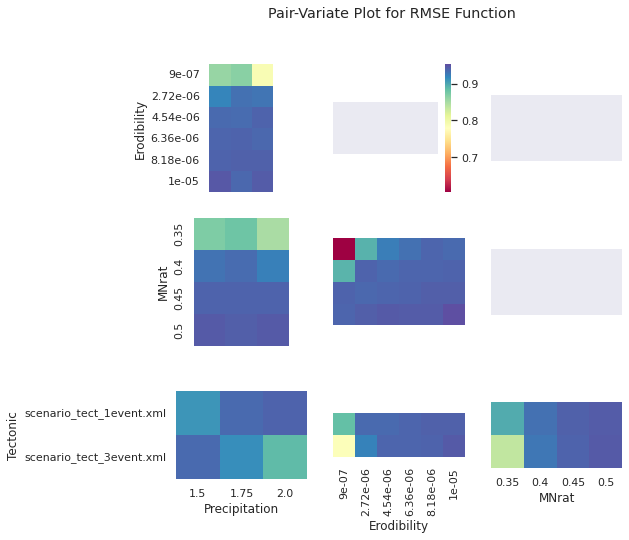

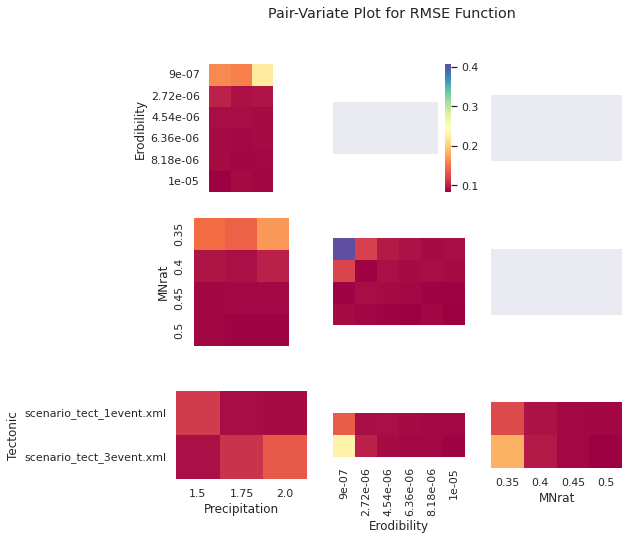

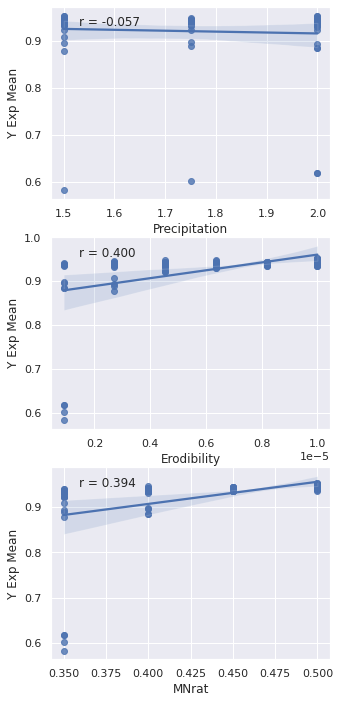

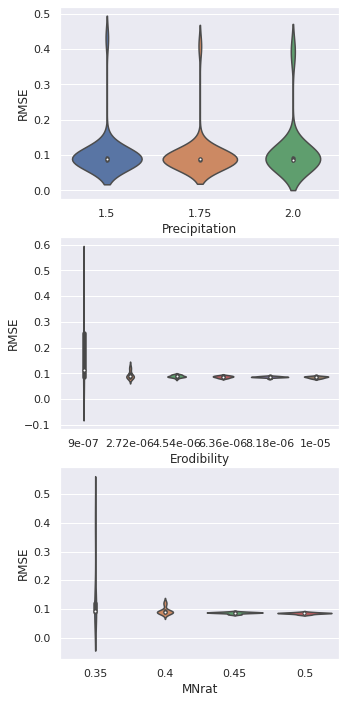

In [5]:
# Here we generate the DoEval results for the thickness only.

import doegen.doeval as doeval
designtable='design_results/Designtable_best_Nrun90 _this_one_used_where_exp86_best_match.csv'
doeval.main('.','./results_final/doeval_well_thickRatio.csv',designtable,'results_final/well_thickness/')


# Similarity Checks
# Next we use similarity measurements between the experiment attributes at a well location and observations.
# Similarity doesn't deal with some types of outliers very well so some filtering, removing wells 
# that have an experimental thickness outside a pre-determined range have their similarities set low.

# next line commented out requires additional wellsim file
#doeval.main('.','results_final/doeval_well_similarity.csv',designtable,'results_final/well_similarity/')


## Plot measured vs. experimental attributes

It's useful to display observations or interpretations from data against the experimental results. Plots of related attributes are available:

![image](./images/experiment_7_Joll01.png "Plots results")

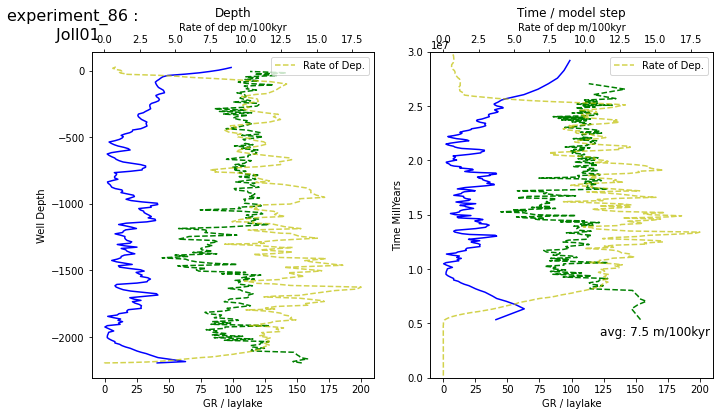

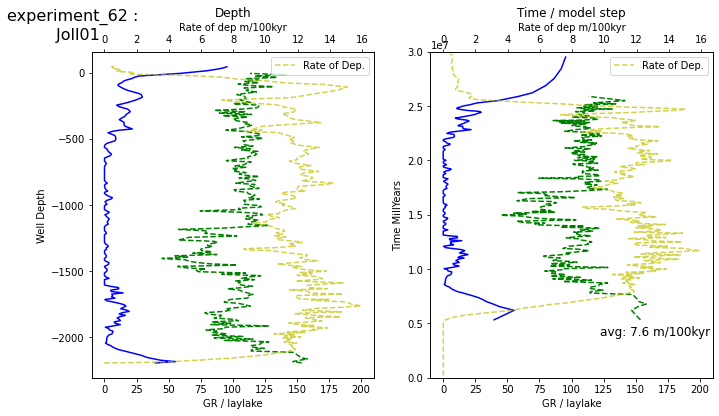

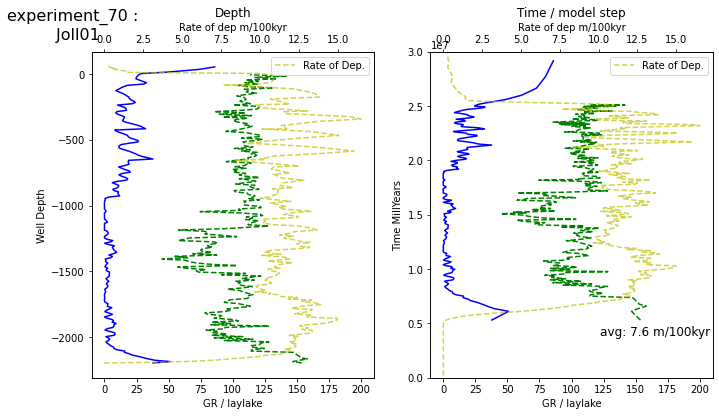

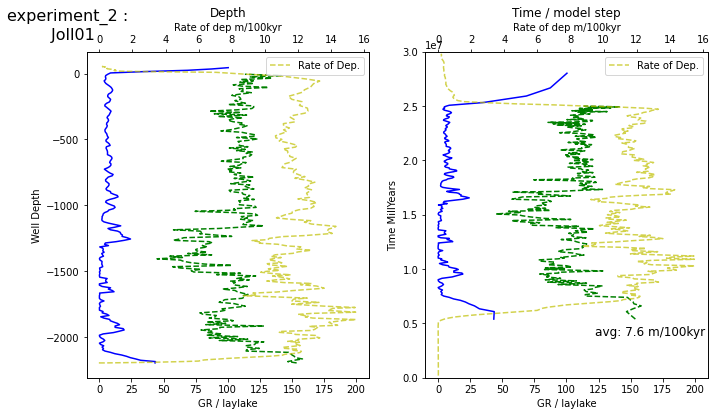

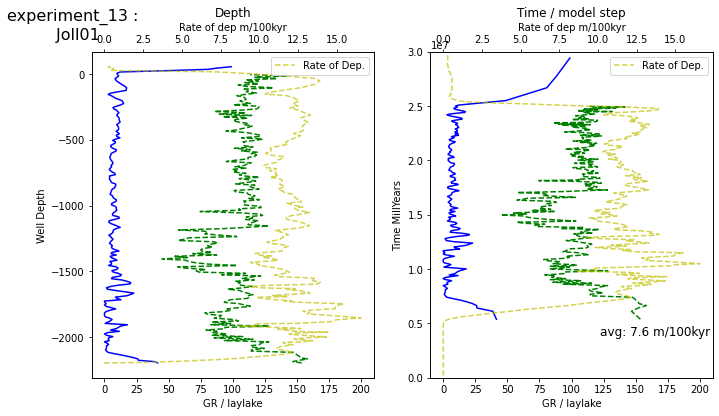

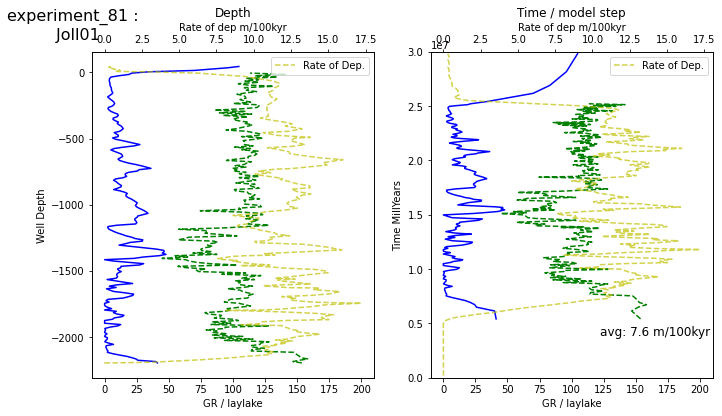

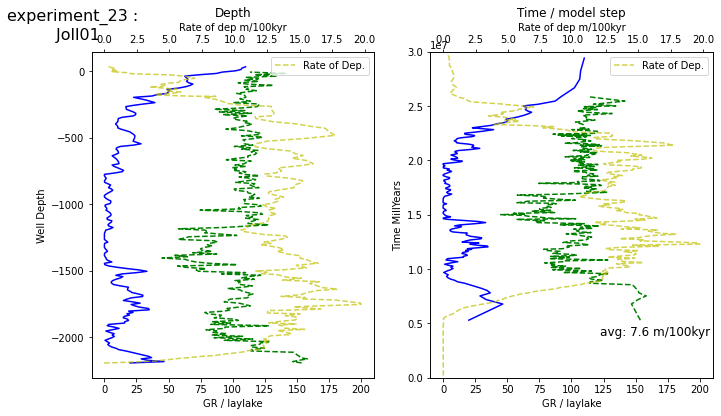

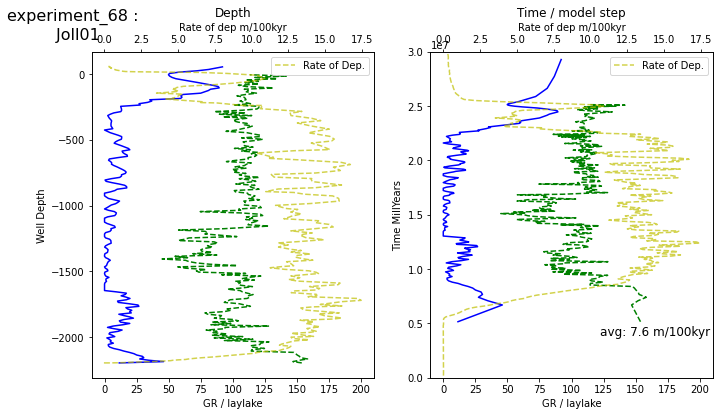

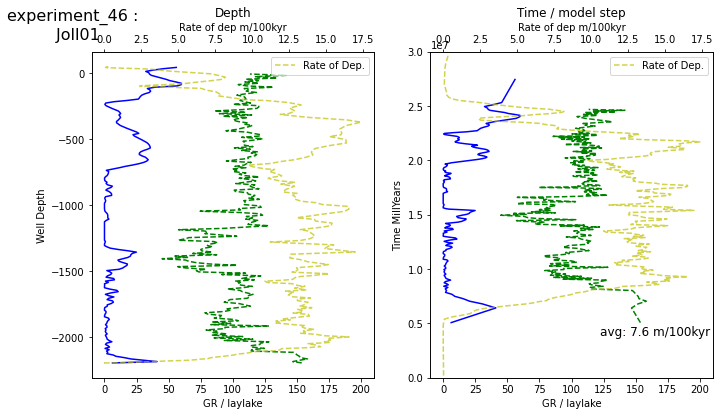

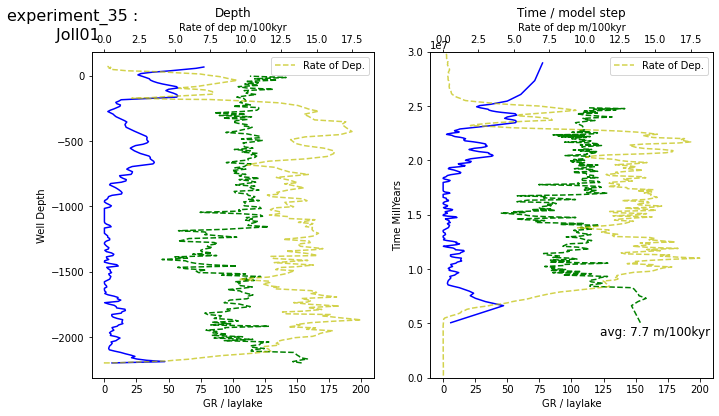

In [15]:
#The well_attr_plot function plots can be produced at any time with the model extracts.
# However, now we have results of the similarity from DoEval, we can plot the top 10 for each "label" in the doeval output.
# Experiment_Joll01_RMSE_Top10_sorted.csv is a sorted list of results from DoEval

import pandas as pd
import badlands_doe_toolset.well_doe_similarity_experimental as wellsim
Joll01_sim=pd.read_csv('results_final/well_similarity/Experiment_Joll01_RMSE_Top10_sorted.csv')
Joll01_sim
wellfile = 'data/well_location_model.csv'
#model_extract=h5py.File(psuedowells,'r')
model_extract='results_final/experiment_well_extracts_90.hdf5'
well_log_file='data/Jolly1_GR.csv' # this is the location of the file with the measured / log property
obslog='GR' #this is name of the column in the measured log or well property to be compared to the experiments

prefix="experiment_"
explog='laylake' # the name of the attribute in the extracted experiment file
Well='Joll01' # the well name string from the well location file.

for i in Joll01_sim['Nexp']:
    Exp=prefix+str(i)
    #print(wellsim.well_attr_sim(model_extract,Exp,Well,obslog,well_log_file,explog,exp_srm=5,log_smth=10))
    wellsim.well_attr_plot(model_extract,Exp,Well,obslog,well_log_file,explog,roll_win=5,exp_srm=10,log_smth=5)
    

In [ ]:
import badlands_doe_toolset.well_doe_similarity as wellsim
#Depending on the number of experiments run it may be useful to plot all of the results.
model_extract='results_final/experiment_well_extracts_90.hdf5'
wellfile = 'data/well_location_model.csv'
wellsim.well_attr_plot_DoEgen(model_extract,'GR',wellfile,'laylake')

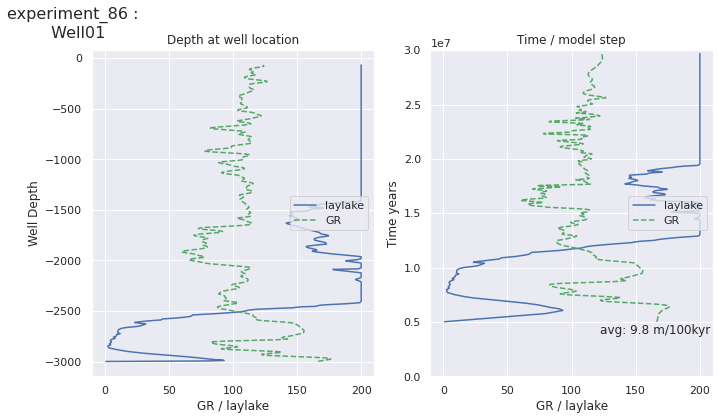

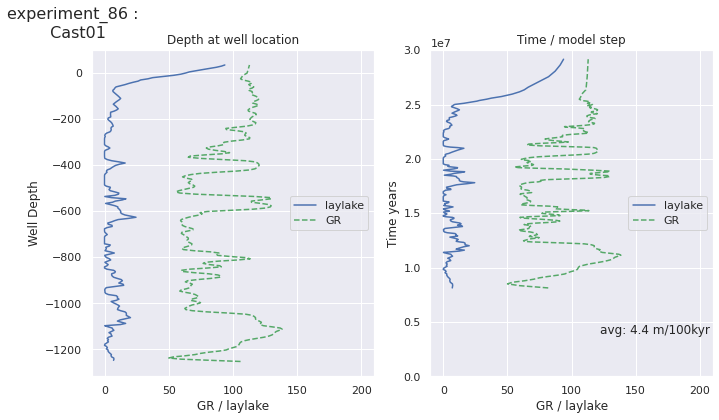

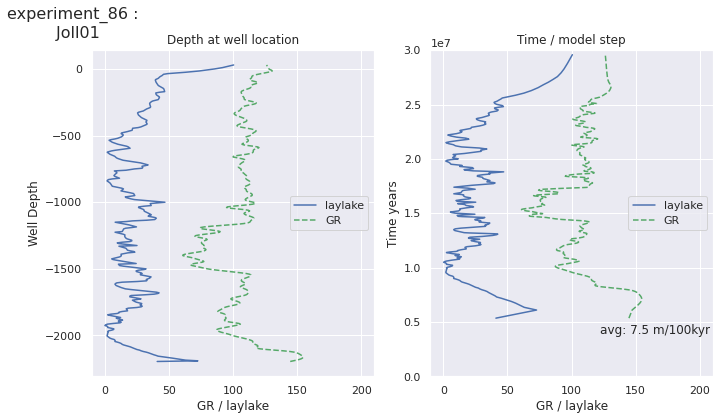

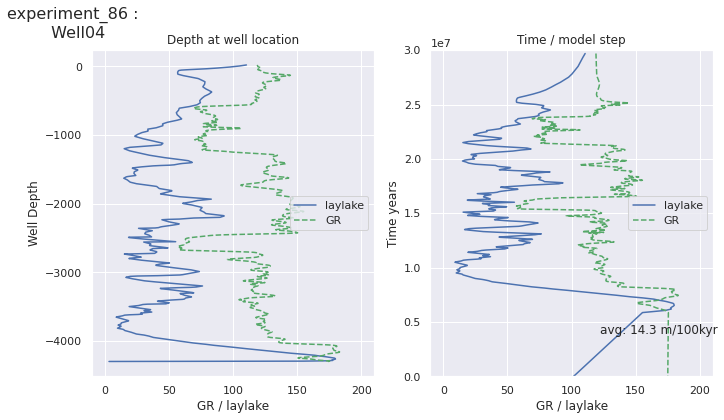

In [3]:
# Or only the results for one experiment
import badlands_doe_toolset.well_doe_similarity as wellsim
model_extract='results_final/experiment_well_extracts_90.hdf5'
wellfile = 'data/well_location_model.csv'

wellsim.exp_attr_plot(model_extract,'experiment_86','GR',wellfile,'laylake')


## Attribution and Acknowledgments
	
This jupyter notebook and code has been extended from a pipeline initially developed by the [Sydney Informatics Hub](https://www.sydney.edu.au/research/facilities/sydney-informatics-hub.html), a core research facility of the University of Sydney, for the [EarthByte](https://www.earthbyte.org/) group.

“This research was supported by the Sydney Informatics Hub, a Core
Research Facility of the University of Sydney.”

In [4]:
# here we extract the sediment thickness and timestep from final tin.time file at given well locations

import badlands_doe_toolset.postproc_utils as ppu
Experiment=  ppu.extract_WellThick_ALL_TIN(xml_dir='badlands_xml',
                                           wellfile= 'data/well_location_model.csv',
                                           outfile='experiment_well_extracts_thick',
                                           outdir='results_final/')

Checking XML files are valid. If there is an error after this then there is something wrong with your configuration xml.
All good, simple xml check passed, number of experiment configuration files loaded: 90
load data from: Experiments/experiment_1/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_2/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_3/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_4/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_5/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_6/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_7/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_8/h5/tin.time300.hdf5
4 psuedo well loc

4 psuedo well locations added to results
load data from: Experiments/experiment_80/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_81/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_82/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_83/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_84/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_85/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_86/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_87/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/experiment_88/h5/tin.time300.hdf5
4 psuedo well locations added to results
load data from: Experiments/expe